In [18]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from functools import reduce
from datetime import date, timedelta, datetime
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
f_name = "res.json"

In [3]:
spark = SparkSession.builder \
        .appName(name="NYC TLC Analysis").master("local[*]").getOrCreate()

25/01/30 14:44:59 WARN Utils: Your hostname, sumins-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.35.30 instead (on interface en0)
25/01/30 14:44:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/30 14:45:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark.sparkContext

<SparkContext master=local[*] appName=NYC TLC Analysis>

### Data Cleaning and Transformation

In [5]:
df = spark.read.parquet("yellow_tripdata_2024-01.parquet")

In [6]:
df_dropna = df.dropna()
df_dropna.count()

2824462

In [7]:
df_trip = df_dropna.withColumn("trip_duration", unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime")))
df_trip.show(1)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|trip_duration|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         186|          79|      

In [8]:
columns_to_check = ["passenger_count", "trip_distance", "fare_amount", 
                    "extra", "mta_tax", "tip_amount", "tolls_amount", 
                    "improvement_surcharge", "total_amount", "congestion_surcharge",
                    "Airport_fee", "trip_duration"]
df_filterd = df_trip.filter(reduce(lambda c1, c2: c1 & c2, [col(c) >= 0 for c in columns_to_check]))
df_filterd.count()

2788942

### Metrics Calculation

In [9]:
trip_duration_avg = df_filterd.agg(avg('trip_duration')).first()[0]
trip_duration_avg

938.6791543173002

In [10]:
trip_distance_avg = df_filterd.agg(avg('trip_distance')).first()[0]
trip_distance_avg

3.2568118627064204

In [11]:
res = {
    "trip_duration_avg":trip_duration_avg,
    "trip_distance_avg":trip_distance_avg
}
with open(f_name, "w") as file:
    json.dump(res, file, indent=4)

### Peak Hours Analysis

In [12]:
df_hour = df_filterd.withColumn("hour", hour("tpep_pickup_datetime"))
df_hour_count = df_hour.groupBy("hour").count().orderBy("hour")
df_hour_count.show()

+----+------+
|hour| count|
+----+------+
|   0| 71015|
|   1| 46655|
|   2| 32990|
|   3| 21369|
|   4| 13474|
|   5| 16366|
|   6| 36654|
|   7| 76208|
|   8|107778|
|   9|122374|
|  10|133130|
|  11|144605|
|  12|157344|
|  13|163103|
|  14|175579|
|  15|181359|
|  16|182663|
|  17|195571|
|  18|200141|
|  19|174191|
+----+------+
only showing top 20 rows



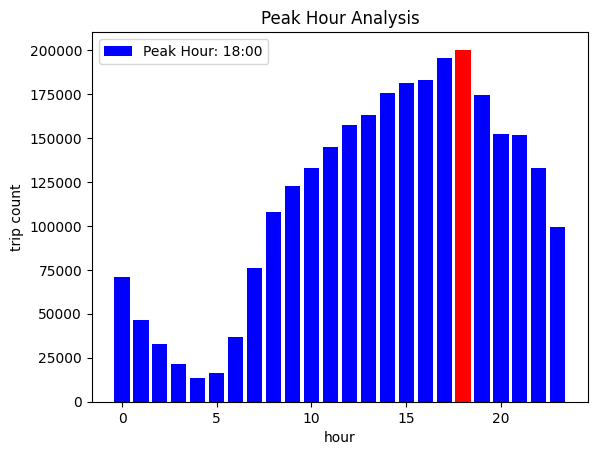

In [13]:
df_hour_count_pd = df_hour_count.toPandas()

max_count = df_hour_count_pd['count'].max()
max_hour = df_hour_count_pd[df_hour_count_pd['count'] == max_count].values[0][0]
colors = ['red' if hour_count == max_count else 'blue' for hour_count in df_hour_count_pd['count']]

plt.bar(df_hour_count_pd['hour'], 
        df_hour_count_pd['count'], 
        color=colors,
        label=f'Peak Hour: {max_hour}:00')
plt.legend()
plt.title("Peak Hour Analysis")
plt.ylabel("trip count")
plt.legend
plt.xlabel("hour");

### Weather Condition Analysis

In [14]:
df_hour.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------+----+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|trip_duration|hour|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+-------------+----+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         186|    

In [15]:
weather_df = spark.read.csv(header=True, path='weather.csv')
weather_df.show()

+-------------------+-----------+--------+----------+-------------+
|           Datetime|Temperature|Humidity|Wind Speed|    Condition|
+-------------------+-----------+--------+----------+-------------+
|2024-01-01 00:51:00|         43|      53|         7|       Cloudy|
|2024-01-01 01:51:00|         43|      53|         9|       Cloudy|
|2024-01-01 02:51:00|         42|      58|         9|       Cloudy|
|2024-01-01 03:51:00|         42|      60|         7|       Cloudy|
|2024-01-01 04:51:00|         42|      60|         5|       Cloudy|
|2024-01-01 05:51:00|         42|      62|         8|       Cloudy|
|2024-01-01 06:13:00|         42|      62|         6|   Light Rain|
|2024-01-01 06:51:00|         41|      67|         8|   Light Rain|
|2024-01-01 07:51:00|         40|      73|         3|   Light Rain|
|2024-01-01 08:51:00|         40|      77|         5|   Light Rain|
|2024-01-01 09:34:00|         41|      73|         6|Mostly Cloudy|
|2024-01-01 09:51:00|         41|      73|      

In [ ]:
joined_df = df_hour.join(
    weather_df,
    (hour(df_hour["tpep_pickup_datetime"]) == hour(weather_df["Datetime"])) &
    (dayofmonth(df_hour["tpep_pickup_datetime"]) == dayofmonth(weather_df["Datetime"])) &
    (month(df_hour["tpep_pickup_datetime"]) == month(weather_df["Datetime"])),
    "inner"
).select(
    "tpep_pickup_datetime", "Datetime", "Temperature", "Humidity","Wind Speed", "Condition"
)

joined_df.show()

+--------------------+-------------------+-----------+--------+----------+---------+
|tpep_pickup_datetime|           Datetime|Temperature|Humidity|Wind Speed|Condition|
+--------------------+-------------------+-----------+--------+----------+---------+
| 2024-01-01 00:57:55|2024-01-01 00:51:00|         43|      53|         7|   Cloudy|
| 2024-01-01 00:03:00|2024-01-01 00:51:00|         43|      53|         7|   Cloudy|
| 2024-01-01 00:17:06|2024-01-01 00:51:00|         43|      53|         7|   Cloudy|
| 2024-01-01 00:36:38|2024-01-01 00:51:00|         43|      53|         7|   Cloudy|
| 2024-01-01 00:46:51|2024-01-01 00:51:00|         43|      53|         7|   Cloudy|
| 2024-01-01 00:54:08|2024-01-01 00:51:00|         43|      53|         7|   Cloudy|
| 2024-01-01 00:49:44|2024-01-01 00:51:00|         43|      53|         7|   Cloudy|
| 2024-01-01 00:30:40|2024-01-01 00:51:00|         43|      53|         7|   Cloudy|
| 2024-01-01 00:26:01|2024-01-01 00:51:00|         43|      53|  

**날씨**   
대체로 흐리거나 비, 눈이 오는날 다른 날씨보다 이용량이 많다   
맑은 날도 이용량이 꽤 되는데 외출 자체를 맑은날에 많이 하기 때문일 수 있을 것 같다.

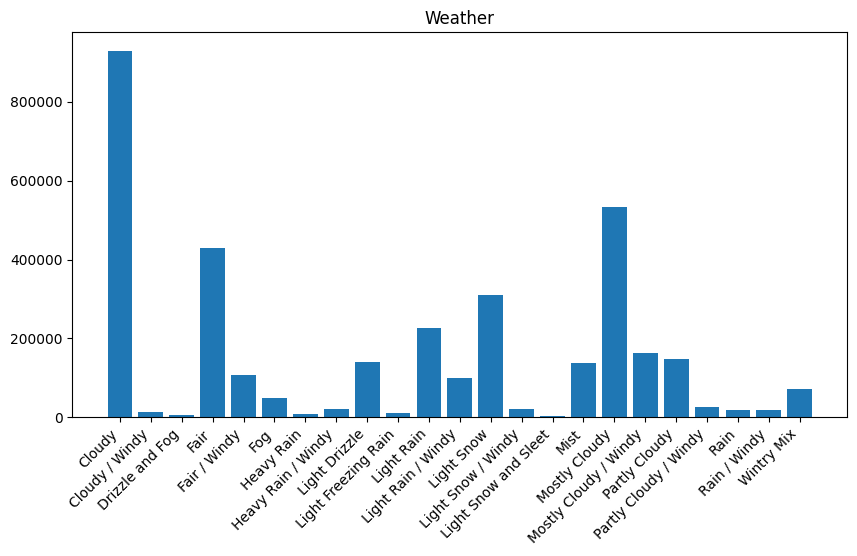

In [36]:
condition_count = joined_df.groupBy('Condition').count().orderBy('Condition').toPandas()
plt.figure(figsize=(10,5))
plt.bar(condition_count['Condition'], condition_count['count'])
plt.title('Weather')
plt.xticks(rotation=45,ha='right');

**온도**   
중간 수준의 온도일 때 이용량이 가장 많은데 한달 기록이다보니 일교차가 비슷하다. 때문에 사람들이 자주 이용하는 시간대의 온도가 빈도가 높게 나온 것 같다.

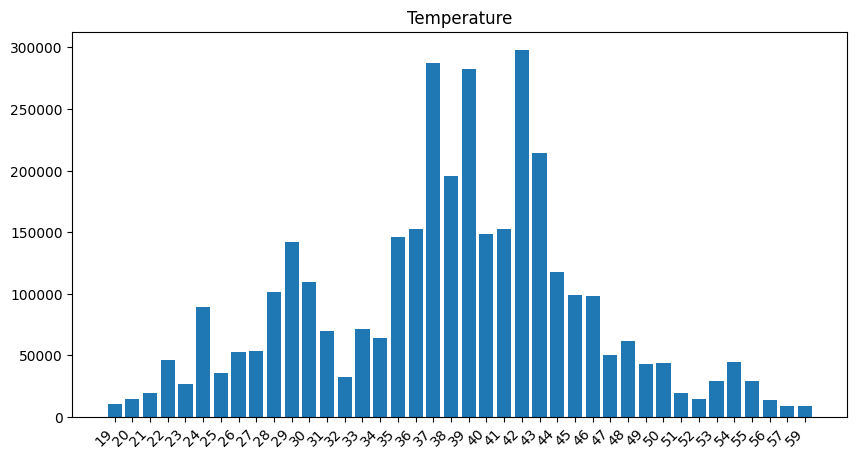

In [40]:
temp_count = joined_df.groupBy('Temperature').count().orderBy('Temperature').toPandas()
plt.figure(figsize=(10,5))
plt.bar(temp_count['Temperature'], temp_count['count'])
plt.title('Temperature')
plt.xticks(rotation=45,ha='right');

가장 많이 이용하는 시간대인 18시의 온도별 사용량을 보았지만 특징이 따로 보이지는 않았음

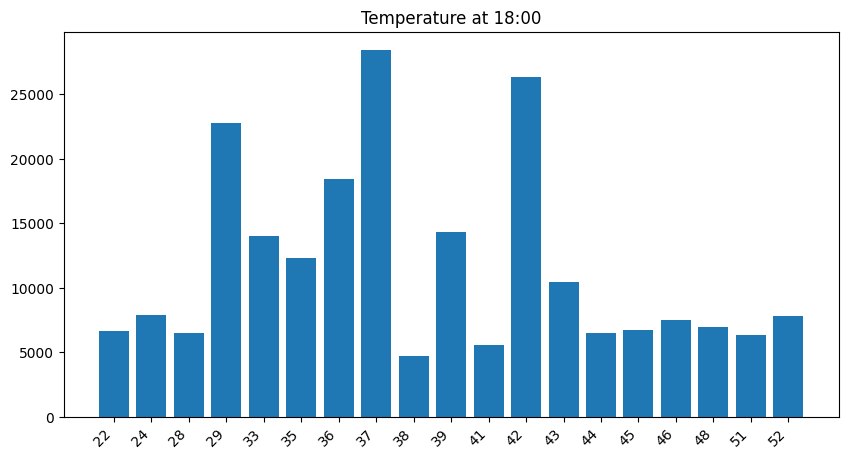

In [53]:
df_to_plot = (joined_df.filter(hour(col("Datetime")) == 18).groupBy("Temperature").count().orderBy("Temperature")).toPandas()
plt.figure(figsize=(10,5))
plt.bar(df_to_plot['Temperature'], df_to_plot['count'])
plt.title('Temperature at 18:00')
plt.xticks(rotation=45,ha='right');

In [55]:
df_to_plot = (
    joined_df.withColumn("Humidity_Range", (floor(col("Humidity") / 10) * 10))
    .count()
    .orderBy(floor(col("Humidity") / 10) * 10)
    .toPandas()
)
df_to_plot
# plt.figure(figsize=(20,5))
# plt.bar(df_to_plot['Humidity'], df_to_plot['count'])
# plt.title('Humidity')
# plt.xticks(rotation=45,ha='right');

,(floor((Humidity / 10)) * 10),count
0,20,33710
1,30,247582
2,40,726726
3,50,542670
4,60,471125
5,70,443742
6,80,847353
7,90,184376
